In [25]:
import pandas as pd
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
import numpy as np

In [26]:

# Load the pretrained Chronos model
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

# Load the CSV data
df = pd.read_csv("/home/jabez/Documents/week_9/Crypto-Trading-Engineering/data/BTC-USD.csv")

# Convert the Date column to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Prepare the context (the Close prices as a torch tensor)
context = torch.tensor(df["Close"].values, dtype=torch.float32)

# Predict the next 12 time steps with 20 samples for uncertainty estimation
forecast = pipeline.predict(
    context=context.unsqueeze(0),  # Adding a batch dimension
    prediction_length=12,
    num_samples=20,
)

# Extract forecast values and calculate quantiles
forecast_values = forecast[0].numpy()  # Assuming forecast returns a tensor
low, median, high = np.percentile(forecast_values, [10, 50, 90], axis=0)

# Generate forecast dates
last_date = df.index[-1]
forecast_dates = pd.date_range(last_date, periods=12 + 1, freq='D')[1:]  # Adjust frequency as needed




/home/jabez/Documents/week_9/Crypto-Trading-Engineering/env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Forecast Dates Range: 2024-06-21 00:00:00 to 2024-07-02 00:00:00
Forecast Values (Median): [64557.234375   64721.91992188 64721.91992188 65215.98046875
 64392.546875   65380.66601562 64721.91992188 65051.29296875
 64886.60546875 65215.97851562 66039.4140625  65545.3515625 ]
Forecast Values (Low 10% Quantile): [63536.171875   63536.171875   62548.05078125 62218.67617187
 61724.61796875 61691.68085938 60868.24648437 60110.68828125
 60440.06328125 60538.875      60242.4375     60868.24648437]
Forecast Values (High 90% Quantile): [65578.2890625  66895.78125    66599.35078125 66401.725
 66994.59296875 67258.09375    67883.90546875 67554.53125
 67554.53125    68345.0234375  69596.6484375  70189.521875  ]


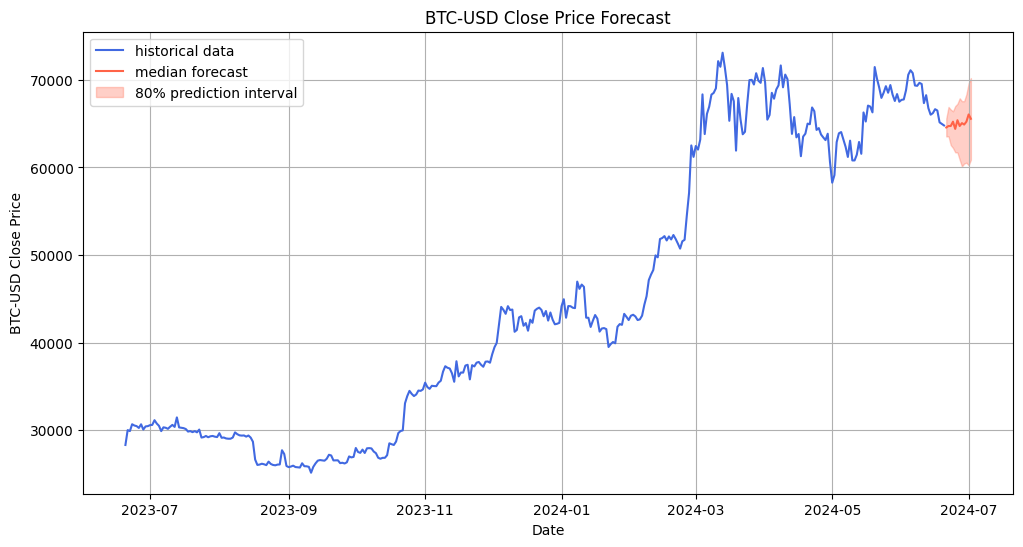

In [27]:
# Print the date range for the forecast
print("Forecast Dates Range:", forecast_dates[0], "to", forecast_dates[-1])

# Print the forecast values
print("Forecast Values (Median):", median)
print("Forecast Values (Low 10% Quantile):", low)
print("Forecast Values (High 90% Quantile):", high)

# Plot the historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], color="royalblue", label="historical data")
plt.plot(forecast_dates, median, color="tomato", label="median forecast")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.xlabel("Date")  # Adding a label to the x-axis
plt.ylabel("BTC-USD Close Price")  # Adding a label to the y-axis
plt.title("BTC-USD Close Price Forecast")  # Adding a title to the plot
plt.show()